---
title: OSI - Oil Spill Index
subtitle: Learn how to use the Oil Spill Index (OSI) to detect oil spills using Sentine-2 data.
authors:
  - name: Juraj Zvolenský
    orcid: 0009-0000-9185-7955
    github: jzvolensky
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
  - name: Michele Claus
    orcid: 0000-0003-3680-381X
    github: clausmichele
    affiliations:
      - id: Eurac Research
        institution: Eurac Research
        ror: 01xt1w755
date: 2025-01-29
thumbnail: https://raw.githubusercontent.com/EOPF-Sample-Service/eopf-sample-notebooks/refs/heads/main/notebooks/static/ESA_logo_2020_Deep.png
keywords: ["earth observation", "remote sensing"]
tags: ["template"]
releaseDate: 2025-08-27
datePublished: 2025-08-27
dateModified: 2025-08-27
github: https://github.com/EOPF-Sample-Service/eopf-sample-notebooks
license: Apache-2.0
---

```{image} ../static/ESA_EOPF_logo_2025_COLOR_ESA_blue_reduced.png
:alt: ESA EOPF Zarr Logo
:width: 250px
:align: center
```

## Table of contents

- [Introduction](#Introduction)
- [Setup](#Setup)
- [Read EOPF-Zarr](#Read-EOPF-Zarr)
- [Spatial and temporal filtering](#Spatial-and-temporal-filtering)
- [Cloud masking](#cloud-masking)
- [Visualize masked data for one date](#visualize-masked-data-for-one-date)
- [Compute OSI](#Compute-OSI)
- [Visualize results](#Visualize-results)

(Introduction_OIL)=
## Introduction

The OSI (Oil Spill Index) uses visible Sentinel-2 bands to display oil spills over water in the costal/marine environment. The OSI is constructed by summing-up the bands representing the shoulders of absorption features of oil as numerator and the band located nearest to the absorption feature as denominator to discriminate oil spill as below.

OSI = (B03 + B04) / B02

The original idea was created by Sankaran Rajendran and is available in the Sentinel Hub documentation [here](https://custom-scripts.sentinel-hub.com/sentinel-2/oil-spill-index/).

## MV Wakashio oil spill

<a data-flickr-embed="true" href="https://www.flickr.com/photos/imo-un/50237761237/in/photostream/" title="IMO helping to mitigate the impacts of MV Wakashio oil spill in Mauritius"><img src="https://live.staticflickr.com/65535/50237761237_b2d6d9e131_b.jpg" width="1024" height="682" alt="IMO helping to mitigate the impacts of MV Wakashio oil spill in Mauritius"/></a><script async src="//embedr.flickr.com/assets/client-code.js" charset="utf-8"></script>

This notebook demonstrates the application of the Oil Spill Index (OSI) to the MV Wakashio oil spill incident in Mauritius using Sentinel-2 imagery.

The incident occured in July 2020 when a Japanese ship ran aground on a coral reef and started leaking fuel oil into the surrounding area for several days.

MV Wakashio was 300 meters long and at the time was carrying roughly 4000 tons of very low sulfur fuel oil (VLSFO). High winds and waves made the cleanup process very difficult. 

More information on the oil spill can be found here:

- [United Nations Office for the Coordination of Humanitarian Affairs (OCHA) - Oil Spill in Mauritius](https://www.unocha.org/publications/report/mauritius/mauritius-mw-wakashio-oil-spill-flash-update-no-1-8-august-2020)

:::{hint} Overview
**Questions**
- How to access Sentinel-2 Zarr data via STAC?
- How to calculate the OSI (Oil Spill Index) using Sentinel-2 data?
- Why is it useful?

**Objectives**
- Access Sentinel-2 Zarr data via STAC.
- Calculate the OSI (Oil Spill Index) using Sentinel-2 data.
- Understand the usefulness of the OSI for detecting oil spills.
- Learn how to visualize the OSI results.
:::

(Setup_OIL)=
## Setup
Start importing the necessary libraries

In [1]:
import os
import xarray as xr
from datetime import datetime
import s3fs
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

from shapely import geometry

from distributed import LocalCluster

In [2]:
cluster = LocalCluster(processes=False)
client = cluster.get_client()
cluster

LocalCluster(03be7e59, 'inproc://10.8.244.70/526683/1', workers=1, threads=4, memory=31.34 GiB)

/home/jzvolensky/miniconda3/envs/eopf-zarr/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)
/home/jzvolensky/miniconda3/envs/eopf-zarr/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/jzvolensky/miniconda3/envs/eopf-zarr/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: divide by zero encountered in divide
  return self.func(*new_argspec)


In [3]:
bucket = "e05ab01a9d56408d82ac32d69a5aae2a:notebook-data"
prefix = "tutorial_data/cpm_v260/"
endpoint_url = "https://objects.eodc.eu:443"

pattern = "S2?_MSIL2A_*_N0500_R091_T40KEC_*.zarr"

fs = s3fs.S3FileSystem(anon=True, client_kwargs={"endpoint_url": endpoint_url})

handlers = fs.s3.meta.events._emitter._handlers
handlers_to_unregister = handlers.prefix_search("before-parameter-build.s3")
if handlers_to_unregister:
    fs.s3.meta.events._emitter.unregister(
        "before-parameter-build.s3", handlers_to_unregister[0]
    )

s3_glob_path = f"{bucket}/{prefix}{pattern}"
matched_paths = fs.glob(s3_glob_path)

zarr_paths = [f"{endpoint_url}/{path}" for path in matched_paths]

len(zarr_paths)

19

(Read-eopf-zarr-data_OIL)=
## Read EOPF Zarr


In [4]:
def extract_time(ds):
    date_format = "%Y%m%dT%H%M%S"
    filename = ds.encoding["source"]
    date_str = os.path.basename(filename).split("_")[2]
    time = datetime.strptime(date_str, date_format)
    return ds.assign_coords(time=time)


r20m = xr.open_mfdataset(
    zarr_paths,
    engine="zarr",
    chunks={},
    group="/measurements/reflectance/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=True,
)

r20m = r20m.sortby("time")

scl = xr.open_mfdataset(
    zarr_paths,
    engine="zarr",
    chunks={},
    group="conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=True,
)

scl = scl.sortby("time")

(Spatial-and-temporal-filtering_OIL)=
## Spatial and temporal filtering

In [5]:
r20m = r20m.rio.write_crs("EPSG:32740")


def spatial_filter(ds: xr.Dataset, bbox: list, epsg: int = 32740):
    x_slice = slice(bbox[0], bbox[2])
    y_slice = slice(bbox[3], bbox[1])
    bbox_polygon = geometry.box(*bbox)
    polygon = gpd.GeoDataFrame(index=[0], crs="epsg:4326", geometry=[bbox_polygon])
    bbox_reproj = polygon.to_crs("epsg:" + str(epsg)).geometry.values[0].bounds
    x_slice = slice(bbox_reproj[0], bbox_reproj[2])
    y_slice = slice(bbox_reproj[3], bbox_reproj[1])
    return ds.sel(x=x_slice, y=y_slice)


def temporal_filter(ds: xr.Dataset, date: datetime):
    return ds.sel(time=date, method="nearest")


dates = [
    datetime(2020, 7, 17),
    datetime(2020, 8, 1),
    datetime(2020, 8, 6),
    datetime(2020, 9, 5),
]
# bbox = [57.70, -20.43, 57.76, -20.53]
bbox = [57.684646751857144, -20.466450832612153, 57.78531132251502, -20.3794154117235]

datasets = []

for date in dates:
    ds_spatial = spatial_filter(r20m, bbox)
    ds_temporal = temporal_filter(ds_spatial, date)
    datasets.append(ds_temporal)

datasets[0]

<xarray.Dataset> Size: 20MB
Dimensions:      (y: 484, x: 528)
Coordinates:
  * x            (x) float32 2kB 5.714e+05 5.714e+05 ... 5.819e+05 5.82e+05
  * y            (y) float32 2kB 7.746e+06 7.746e+06 ... 7.737e+06 7.737e+06
    time         datetime64[ns] 8B 2020-07-17T06:24:49
    spatial_ref  int64 8B 0
Data variables:
    b01          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b02          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b03          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b04          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b05          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b06          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b07          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b11          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b12          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b8a          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>

(cloud-masking_OIL)=
## Cloud masking

In [6]:
slc = xr.open_mfdataset(
    zarr_paths,
    engine="zarr",
    chunks={},
    group="conditions/mask/l2a_classification/r20m",
    concat_dim="time",
    combine="nested",
    preprocess=extract_time,
    decode_cf=False,
    mask_and_scale=True,
)

slc = slc.sortby("time")

slc_masks = []

for date in dates:
    ds_spatial = spatial_filter(slc, bbox)
    ds_temporal = temporal_filter(ds_spatial, date)
    slc_masks.append(ds_temporal)

slc_masks[0]

<xarray.Dataset> Size: 2MB
Dimensions:  (y: 484, x: 528)
Coordinates:
  * x        (x) float32 2kB 5.714e+05 5.714e+05 ... 5.819e+05 5.82e+05
  * y        (y) float32 2kB 7.746e+06 7.746e+06 ... 7.737e+06 7.737e+06
    time     datetime64[ns] 8B 2020-07-17T06:24:49
Data variables:
    scl      (y, x) int64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>

In [7]:
masked_datasets = []

for ds, mask in zip(datasets, slc_masks):
    scl = mask["scl"]

    scl = scl.reindex_like(ds, method="nearest")

    cloud_mask = ~scl.isin([3, 8, 9, 10])

    ds_masked = ds.where(cloud_mask)
    masked_datasets.append(ds_masked)

masked_datasets[0]

<xarray.Dataset> Size: 20MB
Dimensions:      (y: 484, x: 528)
Coordinates:
  * x            (x) float32 2kB 5.714e+05 5.714e+05 ... 5.819e+05 5.82e+05
  * y            (y) float32 2kB 7.746e+06 7.746e+06 ... 7.737e+06 7.737e+06
    time         datetime64[ns] 8B 2020-07-17T06:24:49
    spatial_ref  int64 8B 0
Data variables:
    b01          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b02          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b03          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b04          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b05          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b06          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b07          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b11          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b12          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>
    b8a          (y, x) float64 2MB dask.array<chunksize=(62, 89), meta=np.ndarray>

(Visualize-masked-data-for-one-date_OIL)=
## Visualize masked data for one date

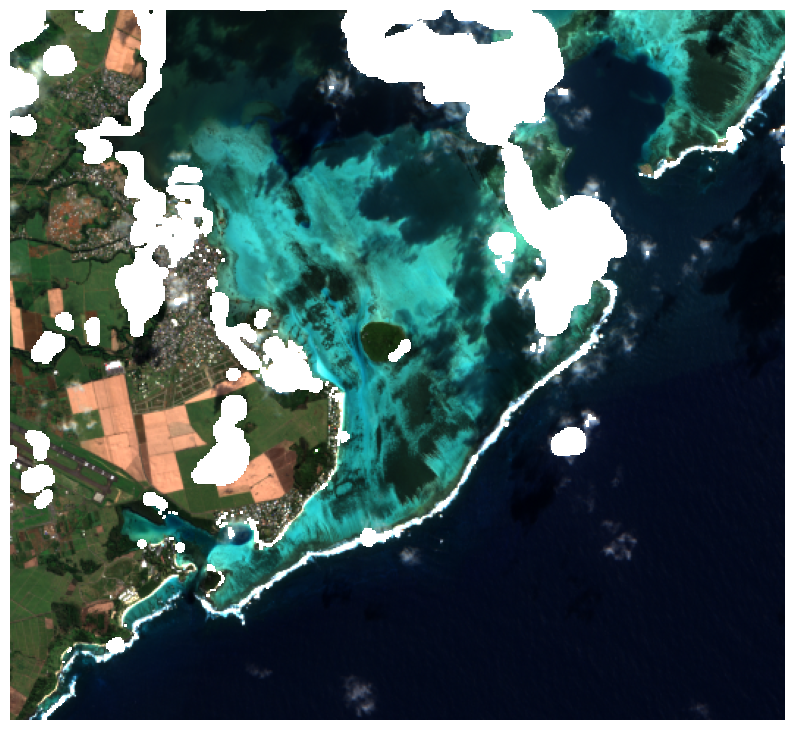

In [8]:
def compute_rgb(dataset):
    b02 = dataset["b02"]
    b03 = dataset["b03"]
    b04 = dataset["b04"]

    rgb = np.stack([b04, b03, b02], axis=-1).astype(float)

    rgb = (rgb / 0.25).clip(0, 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(rgb, origin="upper")
    plt.axis("off")
    plt.show()


ds = masked_datasets[0]
compute_rgb(ds)

(Compute-OSI_OIL)=
## Compute OSI

The standard way of computing OSI is (B03 + B04) / B02.

However, there are several other variants that can be used to compute the OSI, taking advantage of different spectral bands. These variants may provide additional insights or improve the sensitivity of the index to oil spills:


`R: (B05+ B06)/ B07; G: (B03+ B04)/B02; B: (B011+ B012)/ B08`

`R: B03/ B02; G: (B03+ B04)/B02; B: (B06+ B07)/ B05`

`Zakzouk, M., Abou El-Magd, I., Ali, E. M., Abdulaziz, A. M., Rehman, A., & Saba, T. (2024). Novel oil spill indices for sentinel-2 imagery: A case study of natural seepage in Qaruh Island, Kuwait. MethodsX, 12, 102520.`


In this example we compute all variants and visualize them below

In [ ]:
def compute_osi_variants(dataset):
    b02 = dataset["b02"]
    b03 = dataset["b03"]
    b04 = dataset["b04"]
    b05 = dataset["b05"]
    b06 = dataset["b06"]
    b07 = dataset["b07"]
    b08 = dataset["b8a"]
    b11 = dataset["b11"]
    b12 = dataset["b12"]

    osi_variants = {}

    # Variant 1: (B04 + B03) / B02
    osi_variants["OSI_1_(B04+B03)/B02"] = (b04 + b03) / b02

    # Variant 2: ((B05 + B06)/B07 + (B03 + B04)/B02) / ((B11 + B12)/B08)
    R = (b05 + b06) / b07
    G = (b03 + b04) / b02
    B = (b11 + b12) / b08
    osi_variants["OSI_2_((B05+B06)/B07 + (B03+B04)/B02) / ((B11+B12)/B08)"] = (
        R + G
    ) / B

    # Variant 3: ((B03/B02 + (B03+B04)/B02) / ((B06+B07)/B05))
    R = b03 / b02
    G = (b03 + b04) / b02
    B = (b06 + b07) / b05
    osi_variants["OSI_3_((B03/B02 + (B03+B04)/B02) / ((B06+B07)/B05))"] = (R + G) / B

    # --- Create RGB image ---
    rgb = np.stack([b04, b03, b02], axis=-1).astype(float)
    rgb = (rgb / 0.25).clip(0, 1)  # simple linear stretch

    # Combine RGB + OSI variants for plotting
    n = len(osi_variants) + 1  # +1 for RGB
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 6))
    if n == 1:
        axes = [axes]

    # Plot RGB first
    axes[0].imshow(rgb, origin="upper")
    axes[0].set_title("RGB Composite (B04,B03,B02)")
    axes[0].axis("off")

    # Plot OSI variants
    for ax, (name, osi) in zip(axes[1:], osi_variants.items()):
        im = ax.imshow(osi, cmap="plasma", vmin=0, vmax=5)
        ax.set_title(name)
        ax.axis("off")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Index Value")

    plt.tight_layout()
    plt.show()

    return osi_variants

(Visualize-results_OIL)=
## Visualize results

In the following visualizations we can see the different OSI variants computed from the Sentinel-2 imagery for each of the 4 dates.

The more classical approach does show some distinction between oil spill and non-oil spill areas. 

Variant two shows a more pronounced separation between the two classes, indicating its potential effectiveness in detecting oil spills, however, it also highlights the land which may not be ideal.

Variant three appears to visibly show oil spill and non oilspill areas while leaving the land areas less pronounced.


Displayed OSI variants for date: 2020-07-17T06:24:49.000000000


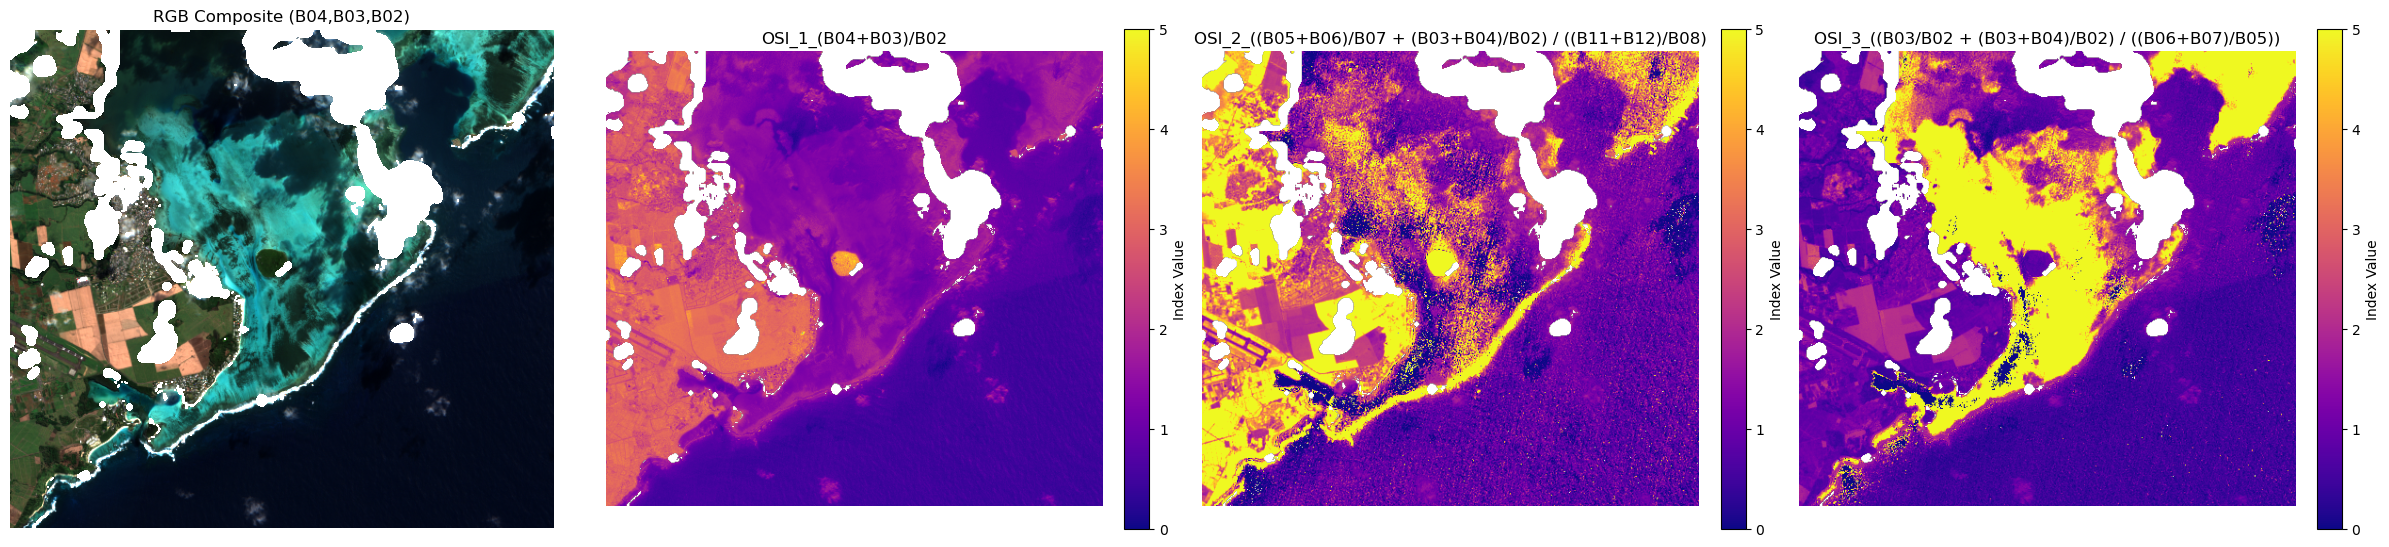

Displayed OSI variants for date: 2020-08-01T06:24:51.000000000


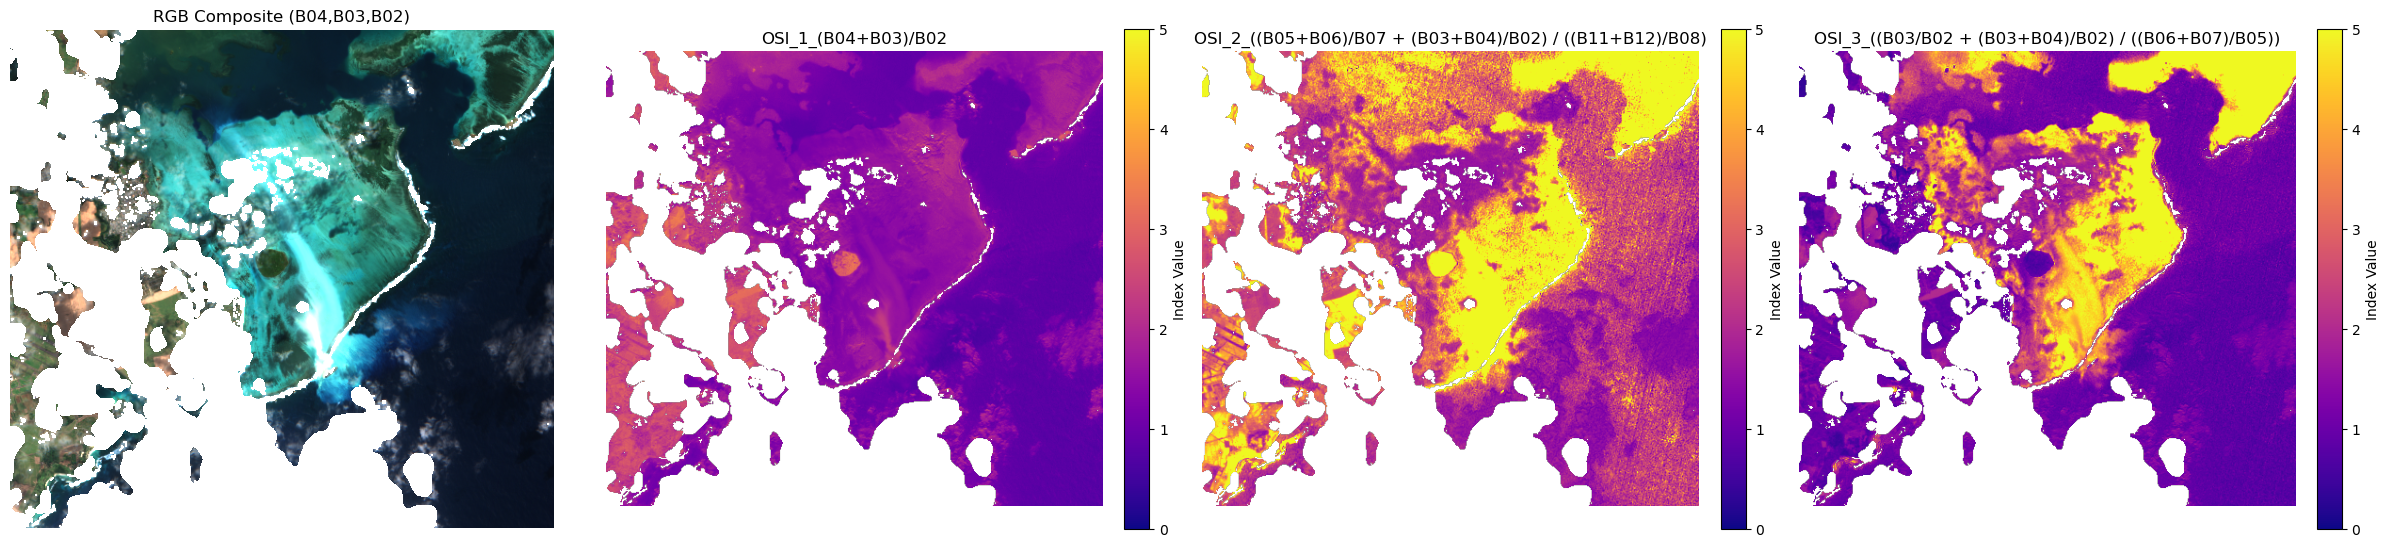

Displayed OSI variants for date: 2020-08-06T06:24:49.000000000


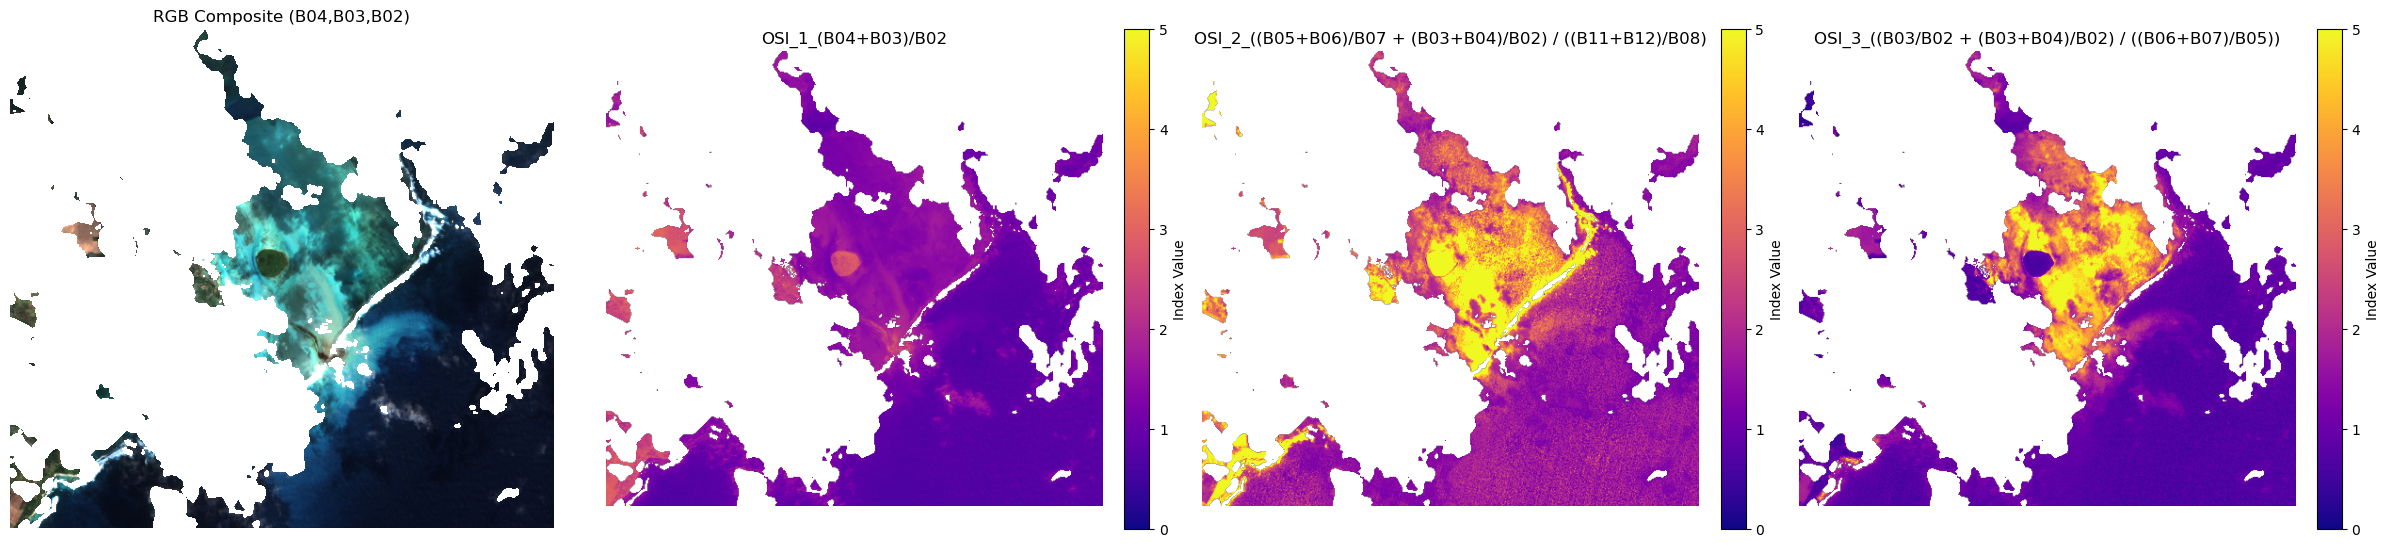

Displayed OSI variants for date: 2020-09-05T06:24:49.000000000


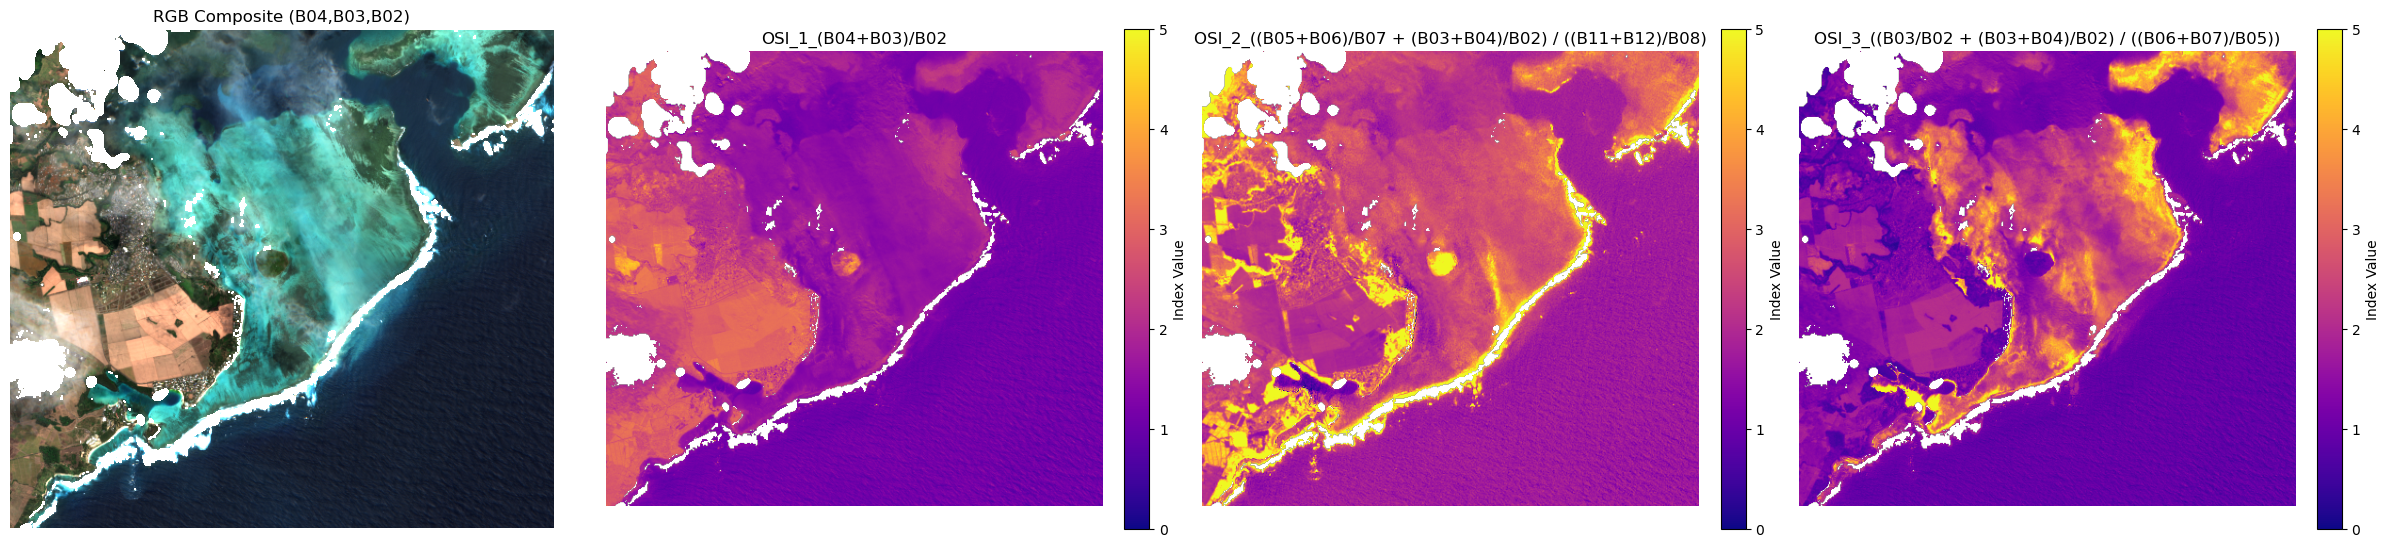

In [12]:
for i in range(4):
    ds = masked_datasets[i]
    print(f"Displayed OSI variants for date: {ds.time.values}")
    compute_osi_variants(ds)

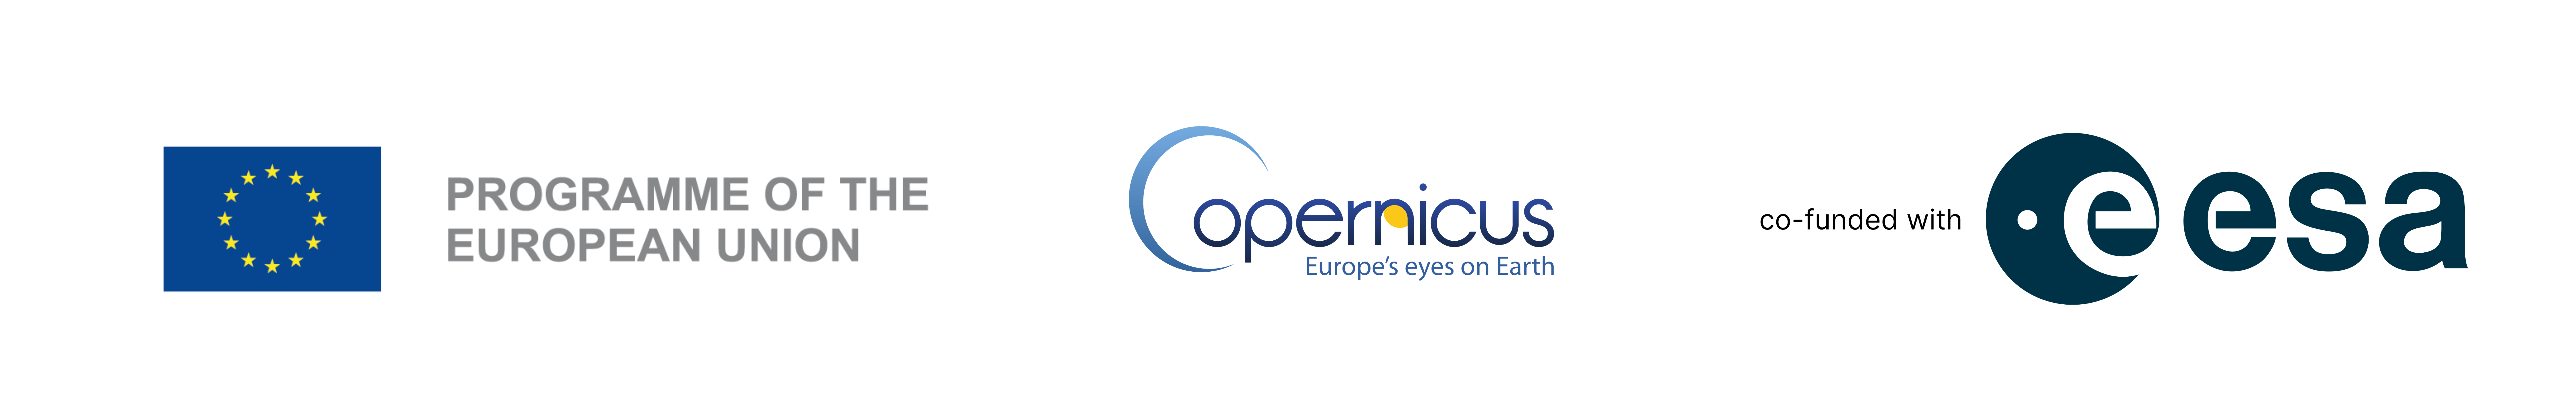